# https://github.com/MorvanZhou/pytorch-A3C/tree/master

In [91]:
import pandas as pd

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/1000.
df_date = df.index

In [92]:
customers = sorted(df.columns.levels[0])
data_test = df[1][['GG', 'GC']]
data_test['GC'].values[1]
data_test.shape

(17520, 2)

In [93]:
from a3c_worker import a3c, Environment
import torch
import torch.nn.functional as F
import numpy as np

capacity = 50.
MPATH = '__pycache__/a3c_gnet.pt'
N_S = 7
N_A = 2
gnet = a3c(N_S, N_A)
gnet.share_memory() 
opt = torch.optim.Adam(gnet.parameters(), lr=1e-4)
gnet.load_state_dict(torch.load(MPATH, weights_only=True))

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])
env = Environment(data_test, capacity)
MAX_EP = data_test.shape[0]

with torch.no_grad():
    state = env.reset()
    for i in range(MAX_EP):
        _, logits = gnet.forward(state)
        action = torch.argmax(logits.unsqueeze(0), dim=1).numpy()[0]
        new_state, reward, done = env.step(action)

        st = np.concatenate((new_state, np.array([action-1, reward.squeeze(0)])))
        df_out.loc[i] = st    
        state = new_state
            

                      PV     LD   BT   AC     GD   RD
2012-07-01 00:30:00  0.0  1.710  5.0 -1.0  1.710  0.0
2012-07-01 01:00:00  0.0  1.572  5.0 -1.0  1.572  0.0
2012-07-01 01:30:00  0.0  1.208  5.0 -1.0  1.208  0.0
2012-07-01 02:00:00  0.0  1.088  5.0 -1.0  1.088  0.0
2012-07-01 02:30:00  0.0  1.194  5.0 -1.0  1.194  0.0
...                  ...    ...  ...  ...    ...  ...
2012-07-05 22:30:00  0.0  0.828  5.0 -1.0  0.828  0.0
2012-07-05 23:00:00  0.0  1.864  5.0 -1.0  1.864  0.0
2012-07-05 23:30:00  0.0  0.140  5.0 -1.0  0.140  0.0
2012-07-06 00:00:00  0.0  0.188  5.0 -1.0  0.188  0.0
2012-07-06 00:30:00  0.0  0.112  5.0 -1.0  0.112  0.0

[241 rows x 6 columns]


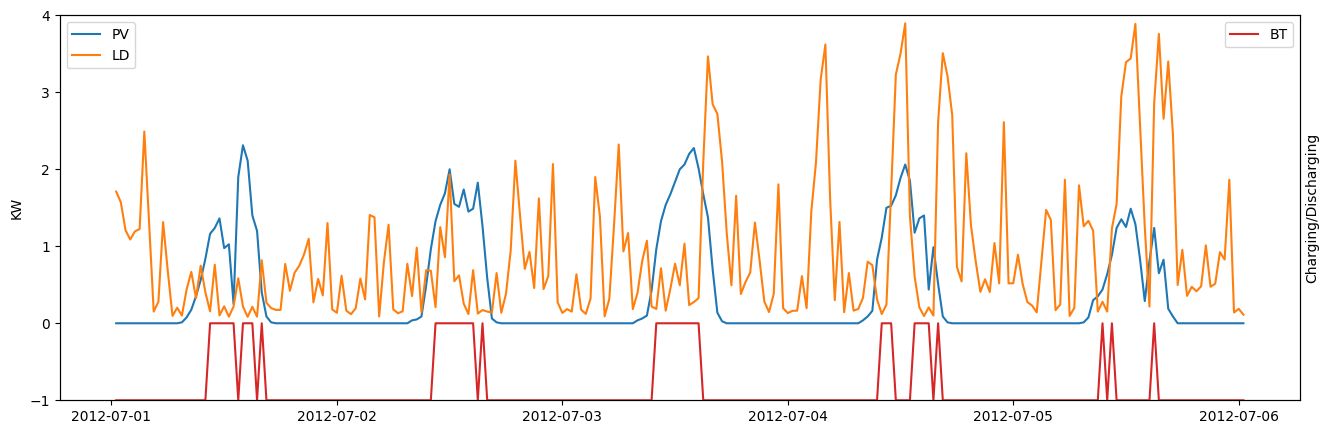

In [94]:
import matplotlib.pyplot as plt

start_pos = TS*0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
# ax1.plot(df_date.values, ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

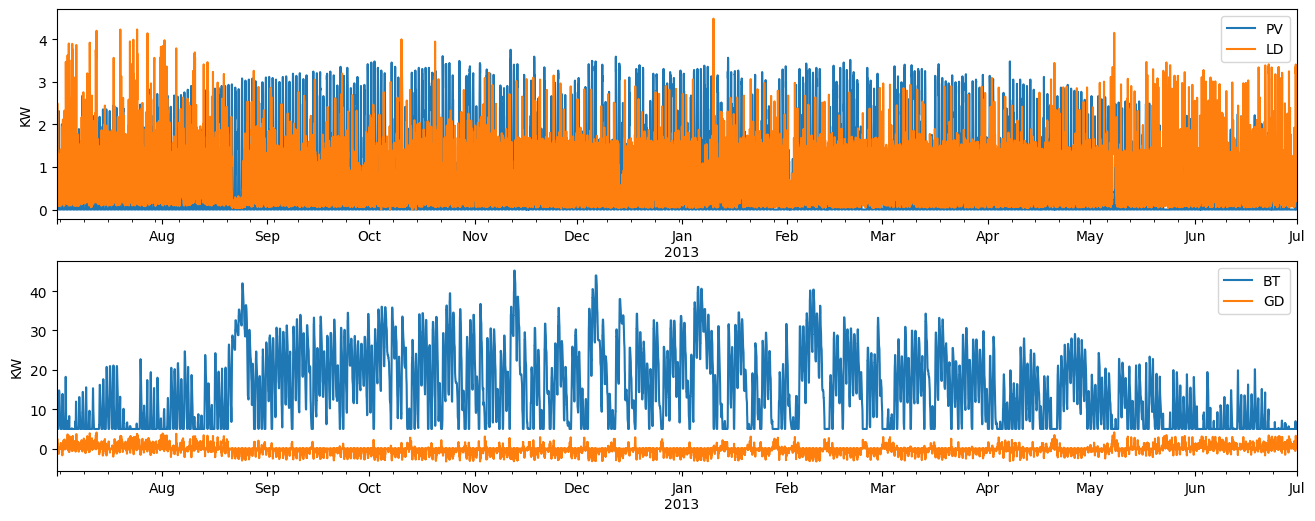

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [96]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

10230.414012374356 KW
10559.768004506826 KW
2998.630000621779
-2669.2759992193896
SC : 0.7390842642349835
SS : 0.7160325880197304
